{ -1 * ((grad(v_0)) : (grad(v_1))) } * dx(<Mesh #1>[everywhere], {})
{ -1 * v_0 * f } * dx(<Mesh #1>[everywhere], {})
{ v_0 * f } * ds(<Mesh #1>[0], {})


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$x$', ylabel='$u(y = 0.50)$'>)

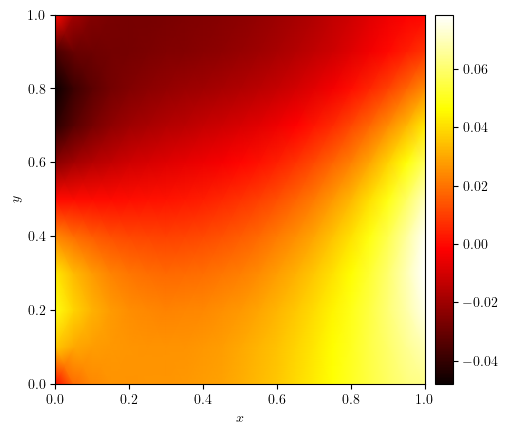

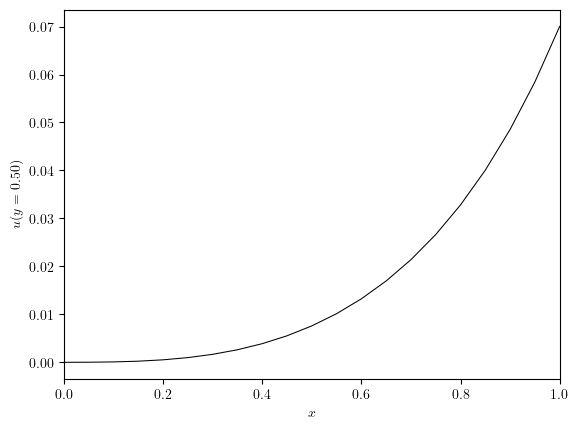

In [ ]:
from ufl.core.expr import Expr
from ufl import Form, inner, grad, TrialFunction, TestFunction, dx, ds
from dolfinx.fem import FunctionSpace

from lucifex.mesh import rectangle_mesh, mesh_boundary
from lucifex.fdm import testfunction, trialfunction
from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.solver import bvp_solver, BoundaryConditions, create_marked_measure
from lucifex.viz import plot_colormap, plot_cross_section


def poisson(
    u: Function,
    f: Function | Constant | Expr,
) -> tuple[Form, Form]:
    """
    `∇²u = f`
    """
    v = testfunction(u)
    F_lhs = -inner(grad(v), grad(trialfunction(u))) * dx
    F_rhs = v * f * dx
    return F_lhs, -F_rhs


Lx = 2.0
Ly = 1.0
mesh = rectangle_mesh(Lx, Ly, 20, 10)
boundary = mesh_boundary(
    mesh, 
    {
        "left": lambda x: x[0],
        "right": lambda x: x[0] - Lx,
        "bottom": lambda x: x[1],
        "top": lambda x: x[1] - Ly,
    },
)


fs = FunctionSpace(mesh, ('P', 1))
f = Function(fs, lambda x: x[0] * x[1] **2, name='f')

u = Function(fs, name='u')
bcs = BoundaryConditions(
    ("dirichlet", boundary['left'], lambda x: x[1] * (Ly - x[1]) * (Ly/2 - x[1])), 
    ("neumann", boundary["right"], lambda x: x[1] * (Ly - x[1])),
)
u_solver = bvp_solver(poisson, bcs)(u, f)
u_solver.solve()

plot_colormap(u)
plot_cross_section(u, 'y', 0.5)
plot_cross_section(u, 'x', 0.5)
